# Model Evaluation

In [24]:
# Import libraries

# Data Structures
import pandas as pd
import numpy as np
from scipy import sparse

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import scikitplot as skplt
cmap = ListedColormap(sns.color_palette('husl',3))
import statsmodels.api as sm

# Modelling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression, RidgeCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, classification_report

import joblib

In [25]:
def model_fitter(model, X_train, y_train, X_test, y_test, cv=5):

    model.fit(X_train, y_train)
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=cv))
    training_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f'cv_score: {cv_score}\ntraining_score: {training_score}\ntest_score: {test_score}')
    return cv_score,training_score,test_score

## Load Data Set

In [4]:
poems = pd.read_parquet('../part-02/datasets/poems-final.parquet')

## `sex` classifier

### Baseline accuracy

In [3]:
# Drop null values from dataset
df_sex = poems.dropna(how='any',subset=['sex']).copy()

# Get baseline accuracy
df_sex.sex.value_counts(normalize=True)

male      0.614118
female    0.385882
Name: sex, dtype: float64

The baseline accuracy for this model is 61.41%.

This means that if we guessed the largest group every time ('male') then we can expect to be correct 61.41% of the time.

For a model to be successful it should predict better than this.

### `NLP`

#### Refit best model

In [7]:
sex_text_only = joblib.load('models/logreg-sex-text-only.jlib').best_estimator_

In [8]:
sex_text_only

LogisticRegression(C=51.79474679231202, max_iter=10000)

We can see the best Logistic Regression model found using our GridSearch has a C value of 51.795 meaning it has applied a penalty of 51.975 times the sum of squares for the beta coefficients. This is to prevent overfitting to the training data.

In [19]:
# Fit best estimator
# Instatiate dictionary to track models
models = {'models': [], 'cv_scores': [], 'training_scores': [], 'test_scores': []}

# Prepare predictor and target variables
X_sex = df_sex[['poem']]
y_sex = df_sex['sex']

# Create for loop to iterate over multiple train-test splits
for i in range(0,10):
    # Prepare train-test-split
    X_sex_train, X_sex_test, y_sex_train, y_sex_test = train_test_split(
        X_sex, y_sex, test_size = 0.3, stratify = y_sex)

    # Instantiate TF-IDF Vectorizer for text data
    tvec = TfidfVectorizer(stop_words = 'english', token_pattern = r'\w+[\'\-]?\w*|[.,/\\\-?;:!_()&]', ngram_range = (1,3))
    tvec.fit(X_sex_train.poem)

    # Transform columns
    X_sex_train = tvec.transform(X_sex_train.poem)
    X_sex_test = tvec.transform(X_sex_test.poem)

    # Stratify kfolds to ensure class distribution
    kf = StratifiedKFold(n_splits = 5)

    # Fit and score model
    print(f'Iteration: {i+1}')
    cv_score, training_score, test_score = model_fitter(sex_text_only, X_sex_train, y_sex_train, X_sex_test, y_sex_test, cv=kf)

    models['models'].append(sex_text_only)
    models['cv_scores'].append(cv_score)
    models['training_scores'].append(training_score)
    models['test_scores'].append(test_score)

Iteration: 1
cv_score: 0.6439426547372515
training_score: 0.9992714404662781
test_score: 0.6518572469045885
Iteration: 2
cv_score: 0.6365521881217564
training_score: 0.9992714404662781
test_score: 0.6499150279193979
Iteration: 3
cv_score: 0.6421733932584757
training_score: 0.9993755203996669
test_score: 0.6504005826656956
Iteration: 4
cv_score: 0.6468566113837909
training_score: 0.9994796003330558
test_score: 0.6491866957999515
Iteration: 5
cv_score: 0.6447766918136312
training_score: 0.9990632805995004
test_score: 0.6477300315610585
Iteration: 6
cv_score: 0.6412367604671735
training_score: 0.9996877601998335
test_score: 0.6465161446953144
Iteration: 7
cv_score: 0.6481059065122278
training_score: 0.9994796003330558
test_score: 0.6431172614712308
Iteration: 8
cv_score: 0.647064619591448
training_score: 0.9993755203996669
test_score: 0.6530711337703327
Iteration: 9
cv_score: 0.6466473572936399
training_score: 0.9992714404662781
test_score: 0.6496722505462491
Iteration: 10
cv_score: 0.641

### Evaluate Accuracy Score

In [23]:
sex_text_only_scores = pd.DataFrame(models)

sex_text_only_scores.drop('models',axis=1,inplace=True)

sex_text_only_scores

,cv_scores,training_scores,test_scores
0,0.643943,0.999271,0.651857
1,0.636552,0.999271,0.649915
2,0.642173,0.999376,0.650401
3,0.646857,0.999480,0.649187
4,0.644777,0.999063,0.647730
5,0.641237,0.999688,0.646516
6,0.648106,0.999480,0.643117
7,0.647065,0.999376,0.653071
8,0.646647,0.999271,0.649672
9,0.641757,0.999376,0.647002


The above dataframe shows the mean cross validation score, the training score, and test score for the best `sex_text_only` model for 10 different train-test splits.

This is to confirm that any improvement on the baseline accuracy is not a function of a lucky train-test split.

From the training scores, we can see the model is still overfitting to the training data - I would rerun the GridSearchCV, increasing the maximum penalty to find the best penalty for this model. For the remaining analysis, I will focus on the mean cv scores, and the test scores.

I will now find the mean of the `cv_scores` column, and the mean of the `test_scores` column.

In [25]:
print(f'Mean CV Score: {sex_text_only_scores.cv_scores.mean()}')
print(f'Mean Test Score: {sex_text_only_scores.test_scores.mean()}')

Mean CV Score: 0.6439112801659298
Mean Test Score: 0.6488468074775431


We can see the above mean CV and test scores are 0.6439 and 0.6488 respectively.

This means that this model has predicted the correct sex based on the poem approximately 64.39% of the time for the cross-validation on the training set, and 64.88% of the time for the test set.

The baseline accuracy for this model was 61.41% - we can see this model has improved on this by approximately 3%.

#### Confusion Matrix and Classification Report

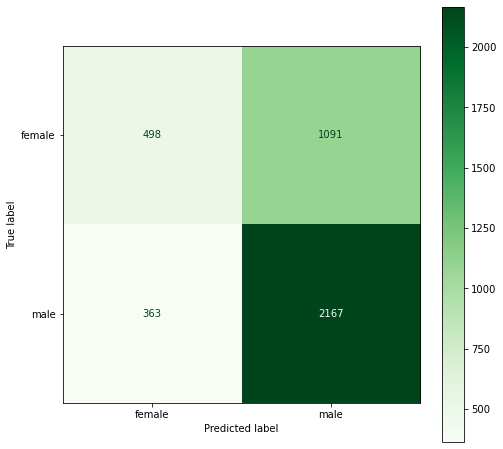

In [34]:
fig,ax = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(sex_text_only, X_sex_test, y_sex_test, cmap = 'Greens', 
        labels = sex_text_only.classes_, ax=ax, values_format = '.0f');

The above confusion matrix shows the intersections between the predicted labels on the x-axis and the true labels on the y-axis.

At first glance it looks like the model is good at classifying poems by male poets, it seems to the be less effective at classifying poems by female poets.

We can look at the classification report for a numerical breakdown:

In [36]:
predictions = sex_text_only.predict(X_sex_test)
print(classification_report(y_sex_test, predictions, digits = 4))

              precision    recall  f1-score   support

      female     0.5784    0.3134    0.4065      1589
        male     0.6651    0.8565    0.7488      2530

    accuracy                         0.6470      4119
   macro avg     0.6218    0.5850    0.5777      4119
weighted avg     0.6317    0.6470    0.6168      4119



This report shows us several metrics to evaluate the performance of this model. The two I will focus on now are the precision and recall scores.

##### Precision - for all the predictions made by the model, how many of those predictions are accurate.

Male -- Of all the cases where male was predicted, 66.51% of those predictions were accurate

Female -- Of all cases where female was predicted, 57.84% of those predictions were accurate.

---------

##### Recall - of all the actual instances of a class, how many of those instances does the model accurately classify.

Male -- Of all actual cases of poems by male poets, 85.65% of them were correctly classified.

Female -- Of all cases of poems by female poets, 31.34% of them were correctly classified as female.

---------

This classification report confirms our suspicions from the confusion matrix: this model is good at classifying poems by male poets, but not as good at classifying poems by female poets. This is unsurprising given the most dominant class in the dataset is male.

One thing we can do to improve this model is to use more predictor columns; the below section will discuss a model introducing two new predictor variables: `number_of_lines` and `number_of_stanzas`.


### `NLP`, `number_of_lines`, `number_of_stanzas`

#### Refit best model

In [6]:
sex_all_grid = joblib.load('models/logreg-sex-allpreds.jlib')
sex_all_grid

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=4,
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                         'max_iter': [10000]},
             verbose=2)

In [7]:
sex_all = sex_all_grid.best_estimator_
sex_all

LogisticRegression(C=35.93813663804626, max_iter=10000)

We can see the best Logistic Regression model found using our GridSearch has a C value of 35.938 meaning it has applied a penalty of 35.938 times the sum of squares for the beta coefficients. This is to prevent overfitting to the training data.

In [12]:
# Fit best estimator
# Instantiate dictionary to track models
models = {'cv_scores': [], 'training_scores': [], 'test_scores': []}

# Prepare predictor and target variables
X_sex = df_sex[['poem','number_of_lines','number_of_stanzas']]
y_sex = df_sex['sex']

# Create for loop to iterate over multiple train-test splits
for i in range(0,10):
    print(f'Iteration: {i+1}')
    # Prepare train-test-split
    print('Preparing train-test-split')
    X_sex_train, X_sex_test, y_sex_train, y_sex_test = train_test_split(
        X_sex, y_sex, test_size = 0.3, stratify = y_sex)

    # Instantiate TF-IDF Vectorizer for text data
    print('Fitting TF-IDF vectorizer')
    tvec = TfidfVectorizer(stop_words = 'english', token_pattern = r'\w+[\'\-]?\w*|[.,/\\\-?;:!_()&]', ngram_range = (1,3))
    tvec.fit(X_sex_train.poem)

    # Instantiate StandardScaler for the numerical data
    print('Fitting Standard Scaler')
    scaler = StandardScaler()
    scaler.fit(X_sex_train[['number_of_lines','number_of_stanzas']])

    # Transform columns
    print('Transforming columns')
    X_sex_train = sparse.hstack((tvec.transform(X_sex_train.poem), scaler.transform(X_sex_train[['number_of_lines','number_of_stanzas']])), format = 'csr')
    X_sex_test = sparse.hstack((tvec.transform(X_sex_test.poem), scaler.transform(X_sex_test[['number_of_lines','number_of_stanzas']])), format='csr')

    # Stratify kfolds to ensure class distribution
    kf = StratifiedKFold(n_splits = 5)

    # Fit and score model
    print('Fitting and scoring model')
    print()
    cv_score, training_score, test_score = model_fitter(sex_all, X_sex_train, y_sex_train, X_sex_test, y_sex_test, cv=kf)

    models['cv_scores'].append(cv_score)
    models['training_scores'].append(training_score)
    models['test_scores'].append(test_score)

Iteration: 1
Preparing train-test-split
Fitting TF-IDF vectorizer
Fitting Standard Scaler
Transforming columns
Fitting and scoring model

cv_score: 0.6492506558487954
training_score: 0.9991673605328892
test_score: 0.6423889293517844
Iteration: 2
Preparing train-test-split
Fitting TF-IDF vectorizer
Fitting Standard Scaler
Transforming columns
Fitting and scoring model

cv_score: 0.6443594836846271
training_score: 0.9991673605328892
test_score: 0.6504005826656956
Iteration: 3
Preparing train-test-split
Fitting TF-IDF vectorizer
Fitting Standard Scaler
Transforming columns
Fitting and scoring model

cv_score: 0.641132864700953
training_score: 0.9994796003330558
test_score: 0.6455450352027191
Iteration: 4
Preparing train-test-split
Fitting TF-IDF vectorizer
Fitting Standard Scaler
Transforming columns
Fitting and scoring model

cv_score: 0.6475871318755786
training_score: 0.9993755203996669
test_score: 0.6472444768147608
Iteration: 5
Preparing train-test-split
Fitting TF-IDF vectorizer
Fit

#### Accuracy Score

In [18]:
sex_all_scores = pd.DataFrame(zip(models['cv_scores'], models['training_scores'], models['test_scores']),
                            columns = ['cv_scores','training_score','test_scores'])

sex_all_scores

,cv_scores,training_score,test_scores
0,0.649251,0.999167,0.642389
1,0.644359,0.999167,0.650401
2,0.641133,0.999480,0.645545
3,0.647587,0.999376,0.647244
4,0.645920,0.999063,0.651372
5,0.642277,0.999271,0.658412
6,0.647481,0.999271,0.655742
7,0.642382,0.999271,0.654285
8,0.641549,0.999376,0.650886
9,0.640195,0.999480,0.658169


The above dataframe shows the mean cross validation score, the training score, and test score for the best `sex_all` model for 10 different train-test splits.

This is to confirm that any improvement on the baseline accuracy is not a function of a lucky train-test split.

From the training scores, we can see the model is still overfitting to the training data - I would rerun the GridSearchCV, increasing the maximum penalty to find the best penalty for this model. For the remaining analysis, I will focus on the mean cv scores, and the test scores.

I will now find the mean of the `cv_scores` column, and the mean of the `test_scores` column.

In [20]:
print(f'Mean CV score: {sex_all_scores.cv_scores.mean()}')
print(f'Mean Test score: {sex_all_scores.test_scores.mean()}')

Mean CV score: 0.6442134445888344
Mean Test score: 0.6514445253702354


We can see the above mean CV and test scores are 0.6442 and 0.6514 respectively.

This means that this model has predicted the correct sex based on the poem approximately 64.42% of the time for the cross-validation on the training set, and 65.14% of the time for the test set.

This model is an improvement on the baseline accuracy (61.41%) by approximately 3%.

It is also a marginal improvement on the accuracy from the previous model:

- Difference in mean CV score: 64.42 - 64.39 = 0.03%
- Difference in mean test score: 65.14 - 64.88 = 0.26%

Using all the predictors, instead of just NLP has slightly improved the model.

#### AUC-ROC Curve

In [24]:
probabilities = pd.DataFrame(sex_all.predict_proba(X_sex_test),columns=sex_all.classes_)
probabilities.head()

,female,male
0,0.349753,0.650247
1,0.272779,0.727221
2,0.349070,0.650930
3,0.239467,0.760533
4,0.594246,0.405754


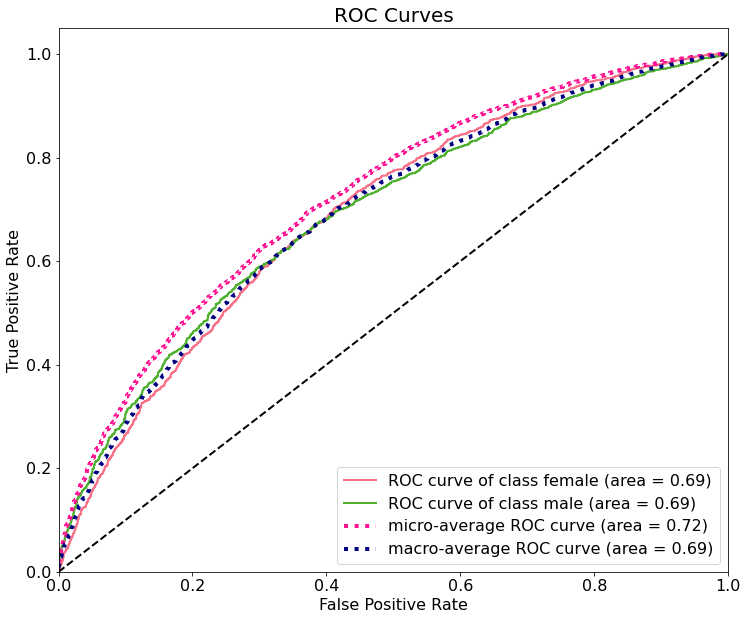

In [25]:
skplt.metrics.plot_roc(y_sex_test, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(12,10), cmap=cmap)
plt.show()

The AUC-ROC curve shows us how much the false positive rate increases as you increase your true positive rate.

The area under the curve is a measure of the separability of both classes: the higher the score is the less intermingling there is between the classes.

For a model that randomly guesses predictions, the expected AUC is 0.5: there should be perfect intermingling of classes because the model is random. In this instance, the macro-average AUC-ROC score (average taken by averaging the other AUC-ROC scores) is 0.69. Since 0.69 > 0.5, we can see that our model performs better than randomly guessing.

#### Confusion Matrix and Classification Report

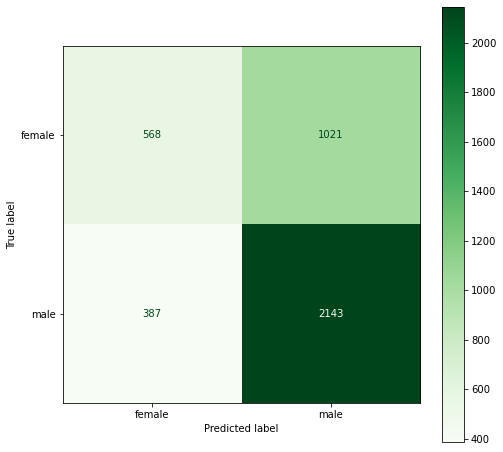

In [38]:
fig,ax = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(sex_all, X_sex_test, y_sex_test, cmap = 'Greens', 
        labels = sex_all.classes_, ax=ax, values_format = '.0f');

The confusion matrix for this model looks broadly similar to that of the previous model.

It is good at classifying poems by male poets, it isn't as good at categorising those by female poets.

We can compare more concretely with a numerical breakdown:

In [40]:
sex_all_predictions = sex_all.predict(X_sex_test)
print(classification_report(y_sex_test,sex_all_predictions,digits=4))

              precision    recall  f1-score   support

      female     0.5948    0.3575    0.4465      1589
        male     0.6773    0.8470    0.7527      2530

    accuracy                         0.6582      4119
   macro avg     0.6360    0.6022    0.5996      4119
weighted avg     0.6455    0.6582    0.6346      4119



Focusing on the precision and recall:

##### Precision

##### Male

For the model using `number_of_lines` and `number_of_stanzas`, of all cases where male was predicted, 67.73% of those predictions were accurate. 

The precision score for the previous model for the male class was 0.6651: of all instances where that model predicted male, 66.51% of those predictions were accurate.

This model has improved the precision score for predicting male by 0.222.

##### Female

For the model using `number_of_lines` and `number_of_stanzas`, of all cases where female was predicted, 59.48% of those predictions were accurate. 

The precision score for the previous model for the female class was 0.5784: of all instances where that model predicted male, 57.84% of those predictions were accurate.

This model has improved the precision score for predicting female by 0.164.

-----

##### Recall

##### Male

The recall score for this model for predicting male is 0.8470. This means that for all instances where a poem was by a male poet, the model correctly classified 84.7% of them. 

For the previous model, the recall score for predicting male was 0.8565. The new model has underperformed against the previous model by 0.0095.

##### Female

The recall score for this model for predicting female is 0.3575. This means that for all instances where a poem was by a female poet, the model correctly classified 35.75% of them. 

For the previous model, the recall score for predicting female was 0.3134. The new model has outperformed the previous model by 0.0441.

-----

#### Summary

The new model improves the old model in the following metrics:
- Accuracy score
- Precision score
    - Male
    - Female
- Recall score
    - Female

The only metric we analysed where the old model outperforms the new model is the recall for male poets. This is to be expected since the model now has a higher chance of classifying a poem as by a female poet than by a male poet. The drop off in recall for male poets is far less than the gain in recall for female poets too.

## `continent` classifier

#### Baseline Accuracy

In [3]:
# Drop null values from dataset
df_cont = poems.dropna(how='any',subset=['continent']).copy()

# Get baseline accuracy
df_cont.continent.value_counts(normalize=True)

north_america    0.673707
europe           0.267808
rest_of_world    0.058485
Name: continent, dtype: float64

The baseline accuracy for this model is 67.37%.

This means that if we guessed the largest group every time ('north_america') then we can expect to be correct 67.37% of the time.

For a model to be successful it should predict better than this.

#### Refit best model

In [4]:
cont_grid = joblib.load('models/logreg-grid-continent.jlib')

cont_lr = cont_grid.best_estimator_
cont_lr

LogisticRegression(C=100.0, max_iter=10000)

We can see the best Logistic Regression model found using our GridSearch has a C value of 100 meaning it has applied a penalty of 100 times the sum of squares for the beta coefficients. This is to prevent overfitting to the training data.

In [8]:
# Fit best estimator

# Prepare predictor and target variables
X_cont = df_cont[['poem','number_of_lines','number_of_stanzas']]
y_cont = df_cont['continent']

# Prepare train-test-split
print('Preparing train-test-split')
X_cont_train, X_cont_test, y_cont_train, y_cont_test = train_test_split(
    X_cont, y_cont, test_size = 0.3, stratify = y_cont)

# Instantiate TF-IDF Vectorizer for text data
print('Fitting TF-IDF vectorizer')
tvec = TfidfVectorizer(stop_words = 'english', token_pattern = r'\w+[\'\-]?\w*|[.,/\\\-?;:!_()&]', ngram_range = (1,3))
tvec.fit(X_cont_train.poem)

# Instantiate StandardScaler for the numerical data
print('Fitting Standard Scaler')
scaler = StandardScaler()
scaler.fit(X_cont_train[['number_of_lines','number_of_stanzas']])

# Transform columns
print('Transforming columns')
X_cont_train = sparse.hstack((tvec.transform(X_cont_train.poem), scaler.transform(X_cont_train[['number_of_lines','number_of_stanzas']])), format = 'csr')
X_cont_test = sparse.hstack((tvec.transform(X_cont_test.poem), scaler.transform(X_cont_test[['number_of_lines','number_of_stanzas']])), format='csr')

# Stratify kfolds to ensure class distribution
kf = StratifiedKFold(n_splits = 5)

# Fit and score model
print('Fitting and scoring model')
print()
cv_score, training_score, test_score = model_fitter(cont_lr, X_cont_train, y_cont_train, X_cont_test, y_cont_test, cv=kf)

models['cv_scores'].append(cv_score)
models['training_scores'].append(training_score)
models['test_scores'].append(test_score)


Preparing train-test-split
Fitting TF-IDF vectorizer
Fitting Standard Scaler
Transforming columns
Fitting and scoring model

cv_score: 0.7614730151650313
training_score: 1.0
test_score: 0.7730112453144523


#### Accuracy Score

The above scores show the mean cross-validation accuracy score, the accuracy score for the training dataset, and the score for the test data set. 

The immediate conclusion we can draw from these scores is that the data has significantly overfit to the training dataset, meaning it does not generalize well.

Having said that, the mean cross-validation score and test score are as follows:

- Mean cross-validation accuracy score: 0.7615
    - For the cross validation folds, this model predicted the right class accurately, on average, 76.15% of the time.
- Test accuracy score: 0.7730
    - For the test data set, the model predicted the correct class 77.3% of the time

Recall above, the baseline accuracy for this model is 0.6737, or in other words we can expect to be correct 67.37% of the time if we predict the largest clas ('north_america') every time.

We can see clearly, the accuracy scores for this model are approximately 9 percentage points higher than the baseline accuracy. This model is an improvement on the baseline accuracy.

#### AUC-ROC Curve

In [9]:
probabilities = pd.DataFrame(cont_lr.predict_proba(X_cont_test),columns=cont_lr.classes_)
probabilities.head()

,europe,north_america,rest_of_world
0,0.001527,0.997956,0.000517
1,0.816023,0.180111,0.003866
2,0.004465,0.991249,0.004286
3,0.108581,0.889491,0.001928
4,0.012041,0.980586,0.007373


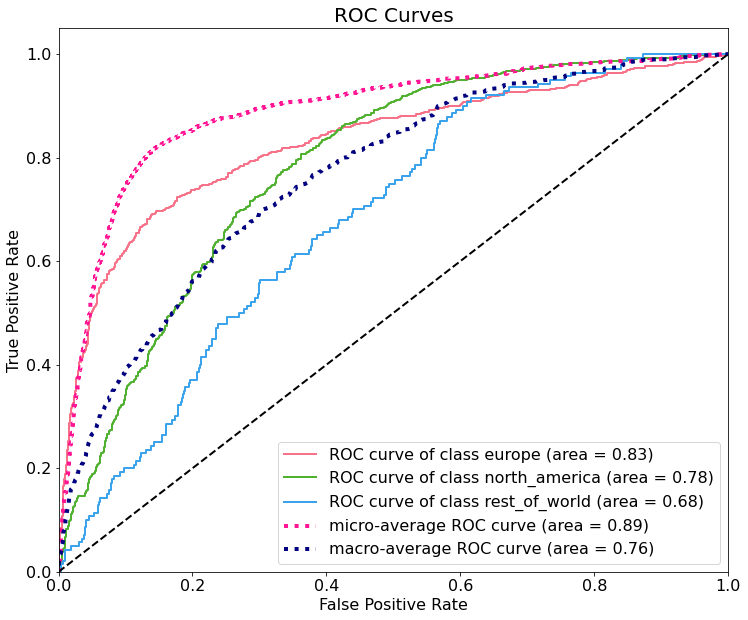

In [10]:
skplt.metrics.plot_roc(y_cont_test, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(12,10), cmap=cmap)
plt.show()

The AUC-ROC shows us how the false positive rate for a given class grows as you increase the true positive rate. A perfect curve would be a vertical line from the origin up the y-axis, and then a horizontal line along the top of the graph. The AUC for a perfect curve is equal to 1. This tells us the closer the score is to 1, the better our model. An AUC score of 0.5 is equivalent to guessing at random.

The AUC score per class is:
- north_america --> 0.78
- europe --> 0.83
- rest_of_world --> 0.68

The first insight is all of these scores are greater than 0.5, and therefore the model is better at classifying each class than randomly guessing.

We can interpret the AUC as the probability that the model assigns a higher proability to a random positive sample belonging to a given class, than a random negative sample.

For example, europe has an AUC of 0.83. We can interpret this as there being a 0.83 probability that the model assigns a higher probability of coming from europe to an actual poem from europe, than a poem from north_america or the rest_of_world.

#### Confusion Matrix and Classification Report

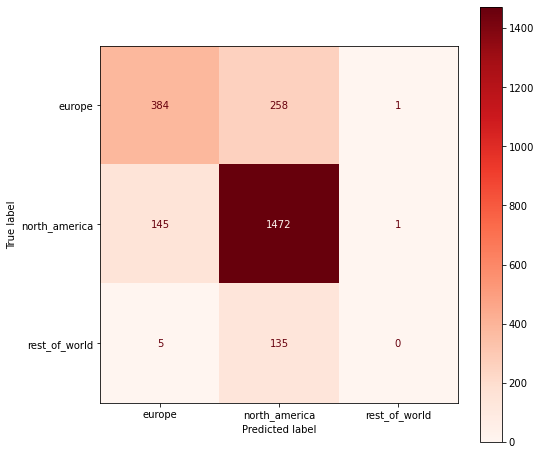

In [12]:
fig,ax = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(cont_lr, X_cont_test, y_cont_test, cmap = 'Reds', 
        labels = cont_lr.classes_, ax=ax, values_format = '.0f');

The classification matrix shows me the following:
- This model has predicted a poem being from the rest_of_world class twice, both times incorrectly
- The model is good at classifying poems from north_america
- The model correctly classified more poems from europe than it misclassified

To get a more detailed view, I will look at the numerical data for a more granular view.

In [13]:
cont_predictions = cont_lr.predict(X_cont_test)
print(classification_report(y_cont_test, cont_predictions, digits=4))

               precision    recall  f1-score   support

       europe     0.7191    0.5972    0.6525       643
north_america     0.7893    0.9098    0.8452      1618
rest_of_world     0.0000    0.0000    0.0000       140

     accuracy                         0.7730      2401
    macro avg     0.5028    0.5023    0.4993      2401
 weighted avg     0.7245    0.7730    0.7443      2401



#### Precision

##### `europe`

The precision score for `europe` was 0.7191. 

This means for every time the model predicted a poem was by a European poet, 71.91% of those predictions were correct.

##### `north_america`

The precision score for `north_america` was 0.7893. 

This means for every time the model predicted a poem was by a North American poet, 78.93% of those predictions were correct.

##### `rest_of_world`

The precision score for `rest_of_world` was 0. 

This means for every time the model predicted a poem was by a poet from somewhere other than North America or Europe, 0% of those predictions were correct.

------
#### Recall

##### `europe`

The recall score for europe is 0.5972.

This means for every actual instance where a poem is by a European poet, the model correctly classifies these poems 59.72% of the time.

##### `north_america`

The recall score for `north_america` is 0.9098.

This means for every actual instance where a poem is by a North American poet, the model correctly classifies these poems 90.98% of the time.

##### `rest_of_world`

The recall score for `rest_of_world` is 0.

This means for every actual instance where a poem is by a poet from somewhere other than Europe or North America, the model correctly classifies these poems 0% of the time.

------

#### Summary

The accuracy scores for this model show it is better at predicting where a poem originates than just predicting the largest class every time. 

This model is very good at classifying poems from `north_america`, and is good at classifying poems from `europe`. It is, however, very poor at classifying poems from the rest of the world. This is unsurprising given the class imbalance within the dataset: only 6% of the poems within the dataset are from the rest of the world. The dominance of the other two classes makes it very unlikely the model will select a poem from the rest of the world.

The following condition is likely to undermine the model's ability to predict the continent of origin accurately (also listed in the executive summary):
- Translated poems may cloud the data set.
    - A poem originating from Germany for example will be said to have originated in Europe. If it was translated by someone from North America, however, the language used is more likely to reflect that used in North America rather than Europe.
    - This may apply to poems from the rest iof the world which may be able to be absorbed into categories.

For a more accurate model, it would be good to identify translated poems and find out who the translator is to better label where the English used comes from. 

Despite this caveat, the model still is a better predictor than simply predicting the baseline prediction every time.



## `dates` regressor

### Baseline Accuracy

In [5]:
df_dates = poems.dropna(how='any',subset=['dates']).copy()
df_dates.dates.mean()

1909.277550481721

The baseline for this model would be to guess the mean accuracy for every poet.

Doing this would mean that we can explain none of the variance within the dataset, the measure for how much of the variance we can explain is called the r_squared score. Predicting the mean every time will yield a r_squared of 0.

For this model to be successful we must get an r-squared better than 0.

### Ridge Regression

#### Refit best model

In [13]:
dates_ridge = joblib.load('models/dates_ridge.jlib')

In [17]:
# Prepare predictor and target columns
X_dates = df_dates[['poem', 'number_of_lines', 'number_of_stanzas']]
y_dates = df_dates['dates']

# Prepare train-test split
X_dates_train, X_dates_test, y_dates_train, y_dates_test = train_test_split(
    X_dates, y_dates, test_size = 0.3, random_state = 42)

# Instantiate TF-IDF Vectorizer for text data
tvec = TfidfVectorizer(stop_words = 'english', token_pattern = r'\w+[\'\-]?\w*|[.,/\\\-?;:!_()&]', ngram_range = (1,3))
print('Fitting TF-IDF Vectorizer')
tvec.fit(X_dates_train.poem)

# Instantiate Standard scaler object for numeric data
scaler = StandardScaler()
print('Fitting Standard Scaler')
scaler.fit(X_dates_train[['number_of_lines','number_of_stanzas']])

# Transform columns
print('Transforming columns')
X_dates_train = sparse.hstack((tvec.transform(X_dates_train.poem),scaler.transform(X_dates_train[['number_of_lines','number_of_stanzas']])), format='csr')
X_dates_test = sparse.hstack((tvec.transform(X_dates_test.poem),scaler.transform(X_dates_test[['number_of_lines','number_of_stanzas']])), format='csr')

# Fit and score model
cv_score, training_score, test_score = model_fitter(dates_ridge, X_dates_train, y_dates_train,
X_dates_test, y_dates_test, cv=10)

Fitting TF-IDF Vectorizer
Fitting Standard Scaler
Transforming columns
cv_score: 0.5608635753475875
training_score: 0.9956834554392998
test_score: 0.5615331539978573


#### R-Squared

The above scores show the mean cross-validation, training and test r-squared scores.

As stated above, the r-squared score is a measure of how much of the vairance within the dataset the model can explain. If we predict the mean for every poem, we can expect an r-squared score of 0. Therefore, anything above 0 is better than simply predicting the mean.

The first conclusion we can see is that the model has again significantly overfit to the training data set. The training score is much higher than the test score meaning it does not generalise well. 

In spite of this, we still have a r-squared scores which are much higher than just guessing the mean:

Mean cross-validation score: 0.5609
Test score: 0.5615

This means that for the cross validation folds and test dataset, this model can explain approximately 56% of the variance.

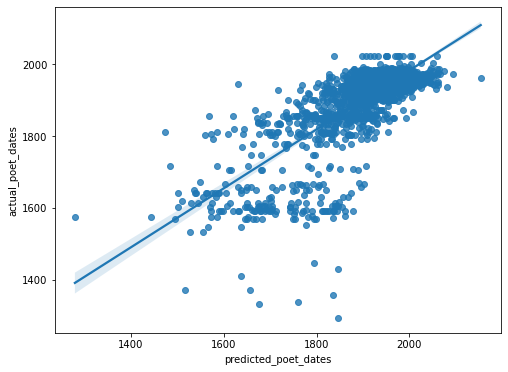

In [33]:
dates_comp = pd.DataFrame(zip(y_dates_test, dates_ridge.predict(X_dates_test)), columns = ['actual_poet_dates','predicted_poet_dates'])

plt.figure(figsize = (8,6))
sns.regplot(x = 'predicted_poet_dates',y='actual_poet_dates',data=dates_comp)
plt.show();

After visualising the data, we can see that the model seems to reduce variance better for poems dating between 1800 and 2000. This is where the data set distribution is most dense. Where the dataset is more sparse (pre-1800), the model is less effective at minimising this variance.

#### Check intercept

In [35]:
dates_ridge.intercept_

1913.3816756588192

The intercept for this model is 1913.38. 

This means that if a poem was entered without any stanzas, lines or words even, then the model would return a predicted date of 1913.38.

This doesn't make any sense in the context of there being no predicted inputs, but the intercept nevertheless makes sense because what it means is: when all other values are equal to 0, when we have no extra information, the model will predict the poem was written in 1913. This is not far from the mean of 1909, and it certainly is a legitimate value to predict.

#### Check for homoscedasticity

In [40]:
dates_comp['residuals'] = dates_comp['actual_poet_dates'] - dates_comp['predicted_poet_dates']

dates_comp.head()

,actual_poet_dates,predicted_poet_dates,residuals
0,1972.0,2035.755186,-63.755186
1,1951.0,1980.007150,-29.007150
2,1968.0,1944.687631,23.312369
3,1855.5,1902.633766,-47.133766
4,1970.0,1898.558309,71.441691


Text(0, 0.5, 'Residuals')

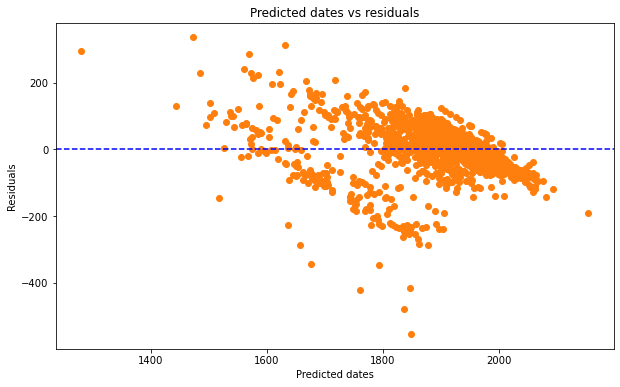

In [50]:
residuals = list(dates_comp['residuals'].values)
predicted_dates = list(dates_comp['predicted_poet_dates'].values)

fig, ax = plt.subplots(figsize = (10,6))

ax.scatter(predicted_dates, residuals, color = 'tab:orange')
ax.axhline(y = 0, color = 'b', linestyle = '--')

ax.set_title('Predicted dates vs residuals')
ax.set_xlabel('Predicted dates')
ax.set_ylabel('Residuals')

What we are looking for in the above plot is to check that at every level of x, the variance is constant. If the variance is not constant, then it becomes difficult to evaluate if a term is statistically significant, a model is more likely to judge a term to be statistically significant than not.

From the above plot, it seems that the assumption of homscedasticity has not been met. the variance in residuals is high for early predictions, but becomes much when the model predicts between 1800 and 2000. 

We can account for this in the future using the following methods:
1. Transform the target variable: we can take the log of the target variable and rerun the model and check if it has eliminated heteroscedasticity.
2. Use weighted regression: we can ssign a weight to each data point based on the variance of its fitted value. This can shrink the sum of squared residuals.

#### Check for normal distribution among residuals

/Users/PatrickPagni/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


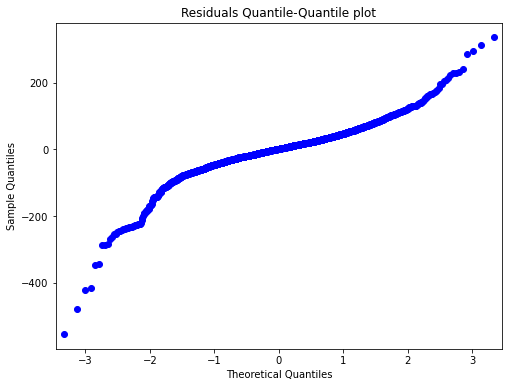

In [61]:
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(dates_comp['residuals'], ax=ax)
ax.set_title('Residuals Quantile-Quantile plot')
plt.show();

Looking at the the above plot, it is clear the residuals do not follow a normal distribution. If they did the would roughly follow a straight diagonal line. 

When this assumption is violated we can either check for outliers or apply a non-linear transformation to the data. The first thing I would try is to transform the target variable. Both the homoscedasticity and normality assumptions are violated, and these may both be fixed by transforming the data.

#### Summary

The r-squared scores for this model set show it has over fit to the training data. 

The cross-validation score, and test score however are both approximately 0.56. This means the model explain 56% of the variance within the dataset. This is considerably better than the baseline prediction.

The intercept for the model is approximately 1913. This means that when al inputs are 0, the model will still predict a meaningful value, which is not far from the mean.

The model, however, violates two assumptions for linear regression models: the assumption of homoscedasticity (that the variance in residuals for every lavel of x is constant) and the assumption that the distribution of residuals is normal. To counter this, I would transform the the dates column by taking the log of it. I would then rerun the model to check if this has solved the problem.

It is important to flag the following limitation for this model as well:
- Translated poems may cloud the data set.
    - If a poem from the 1300s was translated in 1920, the poem is more likely to reflect the language usage of 1920s rather than the 1300s.

I think confirming the translation dates for poems which have been translated would also improve the model.